**1. Install Required Libraries**

In [6]:
#Before running any code, ensure that `torch` and `torchvision` are installed.

#!pip install torch torchvision
import torch
torch.cuda.set_device(0)
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [5]:
#This step mounts your Google Drive so that you can access your project files.

#from google.colab import drive
#drive.mount('/content/drive')

**2. Unzipping Files**

In [ ]:
!pwd

In [2]:
# This extracts the dataset and code files from Google Drive.

import os
import zipfile

# Define paths (corrected for spaces in filenames)
drive_path = "/home/lisic/hash/"
#code_zip = os.path.join(drive_path, "DCGAN_PyTorch_code.zip")  # Correct filename with space
dataset_zip = os.path.join(drive_path, "hash/Anime_Faces_12000.zip")  # Dataset file path
# Extract DCGAN code
#with zipfile.ZipFile(code_zip, 'r') as zip_ref:
   # zip_ref.extractall(os.path.join(drive_path, "DCGAN_Pytorch"))

# Extract Dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(drive_path, "Dataset"))

print("Extraction Complete!")

Extraction Complete!


**3. Dataset Preprocessing**

In [3]:
#This resizes images, converts them to tensors, and normalizes them.

import os
from torchvision import transforms, datasets
from PIL import Image

dataset_dir = os.path.join(drive_path, "Dataset")
processed_dataset_dir = os.path.join(drive_path, "Processed_Dataset")
os.makedirs(processed_dataset_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=None)

for i, (image, _) in enumerate(dataset):
    processed_image = transform(image)
    processed_image_pil = transforms.ToPILImage()(processed_image)
    processed_image_pil.save(os.path.join(processed_dataset_dir, f"processed_{i}.png"))

print(f"Processed and saved {len(dataset)} images in {processed_dataset_dir}.")

Processed and saved 12000 images in /home/lisic/hasseb/Processed_Dataset.


**4. Creating Dummy Class Folder**

In [39]:
#Ensures dataset compatibility with PyTorch’s ImageFolder format.

import shutil

def move_images_to_class_folder(source_dir):
    class_folder = os.path.join(source_dir, "class_0")
    os.makedirs(class_folder, exist_ok=True)
    for image_name in os.listdir(source_dir):
        if image_name.endswith(('jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp')):
            shutil.move(os.path.join(source_dir, image_name), os.path.join(class_folder, image_name))

move_images_to_class_folder(processed_dataset_dir)
print("Images moved to 'class_0' subfolder.")

Images moved to 'class_0' subfolder.


**5. Creating Data Loader**

In [40]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define dataset transformation (Ensure this is the same as in preprocessing)
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ensure that processed dataset path is correctly set
processed_dataset_dir = "/home/lisic/hash/Processed_Dataset"

# Load the dataset
combined_dataset = datasets.ImageFolder(root=processed_dataset_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=2)

print("Dataloader is now defined and ready to use.")

Dataloader is now defined and ready to use.


**6. Creating Folder for Generated Images**

In [41]:
#Generated images from the model will be stored here.

generated_images_dir = os.path.join(drive_path, "Generated_Images")
os.makedirs(generated_images_dir, exist_ok=True)
print(f"Generated images will be stored in: {generated_images_dir}")

Generated images will be stored in: /home/lisic/hasseb/Generated_Images


**7. Initialize Model and Optimizers**

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse

# Define opt before using it
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.0002)
parser.add_argument("--b1", type=float, default=0.5)
parser.add_argument("--b2", type=float, default=0.999)
parser.add_argument("--latent_dim", type=int, default=100)
parser.add_argument("--img_size", type=int, default=64)
parser.add_argument("--channels", type=int, default=3)
parser.add_argument("--sample_interval", type=int, default=400)
opt = parser.parse_args(args=[])

adversarial_loss = nn.BCELoss()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

print("Models, optimizers, and loss function initialized successfully!")

Models, optimizers, and loss function initialized successfully!


**8. Initial Run and Test Code Script**

In [43]:
# Before full training, we run a small test to verify that the model is working properly by generating images from a few batches.

# This must be run after the model and dataloader are defined** to avoid errors.

import torch
from torchvision.utils import save_image

def test_model(generator, dataloader, test_output_dir, num_batches=3):
    os.makedirs(test_output_dir, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i, (imgs, _) in enumerate(dataloader):
            if i >= num_batches:
                break  # Run on a few batches only for testing
            z = torch.randn(imgs.shape[0], opt.latent_dim, device='cuda' if torch.cuda.is_available() else 'cpu')
            gen_imgs = generator(z)
            save_image(gen_imgs, os.path.join(test_output_dir, f"test_batch_{i}.png"), nrow=5, normalize=True)
            print(f"Saved test batch {i} images in {test_output_dir}")

test_output_dir = os.path.join(drive_path, "Test_Generated_Images")

# Ensure this section runs after model and dataloader initialization
try:
    test_model(generator, dataloader, test_output_dir)
    print("Initial test run complete. Now starting full training...")
except NameError:
    print("Error: Ensure that the model and dataloader are defined before running the test script.")

Saved test batch 0 images in /home/lisic/hasseb/Test_Generated_Images
Saved test batch 1 images in /home/lisic/hasseb/Test_Generated_Images
Saved test batch 2 images in /home/lisic/hasseb/Test_Generated_Images
Initial test run complete. Now starting full training...


**9. Model Training**

[Epoch 0/50] [Batch 0/188] [D loss: 0.6919234991073608] [G loss: 0.6865072250366211]
[Epoch 0/50] [Batch 1/188] [D loss: 0.6900372505187988] [G loss: 0.6869913339614868]
[Epoch 0/50] [Batch 2/188] [D loss: 0.6887507438659668] [G loss: 0.6876316070556641]
[Epoch 0/50] [Batch 3/188] [D loss: 0.6867610812187195] [G loss: 0.6877893209457397]
[Epoch 0/50] [Batch 4/188] [D loss: 0.6861798763275146] [G loss: 0.6886674165725708]
[Epoch 0/50] [Batch 5/188] [D loss: 0.6837621927261353] [G loss: 0.6892270445823669]
[Epoch 0/50] [Batch 6/188] [D loss: 0.6814917325973511] [G loss: 0.6897070407867432]
[Epoch 0/50] [Batch 7/188] [D loss: 0.6795172691345215] [G loss: 0.6902122497558594]
[Epoch 0/50] [Batch 8/188] [D loss: 0.6741764545440674] [G loss: 0.6907615661621094]
[Epoch 0/50] [Batch 9/188] [D loss: 0.6743892431259155] [G loss: 0.6914883852005005]
[Epoch 0/50] [Batch 10/188] [D loss: 0.6722384691238403] [G loss: 0.690590500831604]
[Epoch 0/50] [Batch 11/188] [D loss: 0.6652408838272095] [G loss:

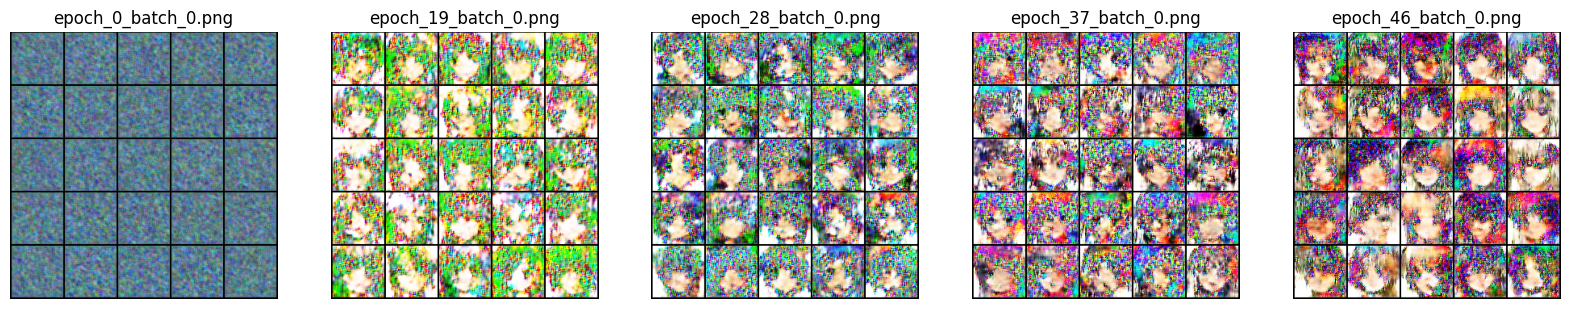

In [44]:
# This step sets up the training process and logs progress.

import os
import argparse
import numpy as np
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import logging
import torch

# Ensure drive_path is defined
drive_path = "/home/lisic/hasseb/"

# Define log file paths
local_log_file = 'training.log'
drive_log_file = os.path.join(drive_path, 'training.log')

# Setup logging
logging.basicConfig(level=logging.INFO, handlers=[
    logging.FileHandler(local_log_file),
    logging.FileHandler(drive_log_file)
])

# Define directories for generated images and saved models
generated_images_dir = os.path.join(drive_path, "generated_images")
model_save_dir = os.path.join(drive_path, "saved_models")
os.makedirs(generated_images_dir, exist_ok=True)  # Ensure directory exists
os.makedirs(model_save_dir, exist_ok=True)  # Ensure model directory exists

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.0001)
parser.add_argument("--b1", type=float, default=0.5)
parser.add_argument("--b2", type=float, default=0.999)
parser.add_argument("--latent_dim", type=int, default=100)
parser.add_argument("--img_size", type=int, default=64)
parser.add_argument("--channels", type=int, default=3)
parser.add_argument("--sample_interval", type=int, default=400)
opt = parser.parse_args(args=[])

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))

        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Save generated images at interval
        if i % opt.sample_interval == 0:
            save_path = os.path.join(generated_images_dir, f"epoch_{epoch}_batch_{i}.png")
            save_image(gen_imgs.data[:25], save_path, nrow=5, normalize=True)

        # Print and log every batch
        log_message = f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        print(log_message)

        with open(drive_log_file, 'a') as log_file:
            log_file.write(log_message + "\n")

    # Save model checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        generator_save_path = os.path.join(model_save_dir, f"generator_epoch_{epoch+1}.pth")
        discriminator_save_path = os.path.join(model_save_dir, f"discriminator_epoch_{epoch+1}.pth")

        torch.save(generator.state_dict(), generator_save_path)
        torch.save(discriminator.state_dict(), discriminator_save_path)

        print(f"Models saved at epoch {epoch+1}!")

# Training Complete! Logs are saved in both local storage and Google Drive.

import matplotlib.pyplot as plt
import glob
from PIL import Image

def plot_generated_images(epoch_interval=10):
    image_files = sorted(glob.glob(os.path.join(generated_images_dir, "*.png")))
    selected_images = image_files[::epoch_interval]  # Select images at intervals

    fig, axes = plt.subplots(1, len(selected_images), figsize=(20, 5))
    for ax, img_path in zip(axes, selected_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(img_path.split("/")[-1])

    plt.show()

# Call function to plot generated images
plot_generated_images()